
--- Predicted Cluster: 1 ---
Distance from cluster center (scaled): 2.7800
Cluster explanation: Cluster 1: Younger customers, frequent returns, lower loyalty points.

Customer input feature values:
  Age: 28.0
  Gender: 1.0
  Spending_Score_Range: 60.0
  Customer_Loyalty_Points: 120.0
  Repeat_Purchase_Frequency: 3.0
  Discount_Impact: 1.0
  Delivery_Timeliness: 2.0
  Returned: 0.0
  Price: 2999.0
  Quantity: 2.0
  Annual Income (k$): 45.0

Percentile ranks within cluster:
  Age: 23.4th percentile
  Gender: 46.3th percentile
  Spending_Score_Range: 55.1th percentile
  Customer_Loyalty_Points: 93.7th percentile
  Repeat_Purchase_Frequency: 26.7th percentile
  Discount_Impact: 33.1th percentile
  Delivery_Timeliness: 0.0th percentile
  Returned: 0.0th percentile
  Price: 70.8th percentile
  Quantity: 8.8th percentile
  Annual Income (k$): 0.6th percentile

Cluster summary statistics (mean ± std):


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Mean,Median,StdDev
Age,30.774105,31.0,5.941119
Gender,0.537190,1.0,0.499303
Spending_Score_Range,53.911846,54.0,27.159910
Customer_Loyalty_Points,68.953168,50.0,40.548798
Repeat_Purchase_Frequency,4.493113,4.0,2.429522
Discount_Impact,2.683196,3.0,2.066951
Delivery_Timeliness,2.000000,2.0,0.000000
Returned,0.000000,0.0,0.000000
Price,3688.789917,700.0,9511.876488
Quantity,6.060606,6.0,3.145929


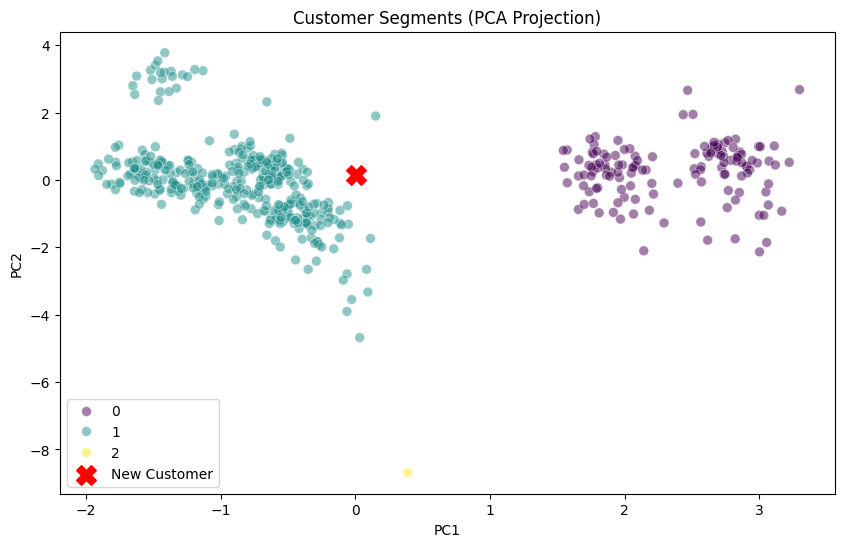

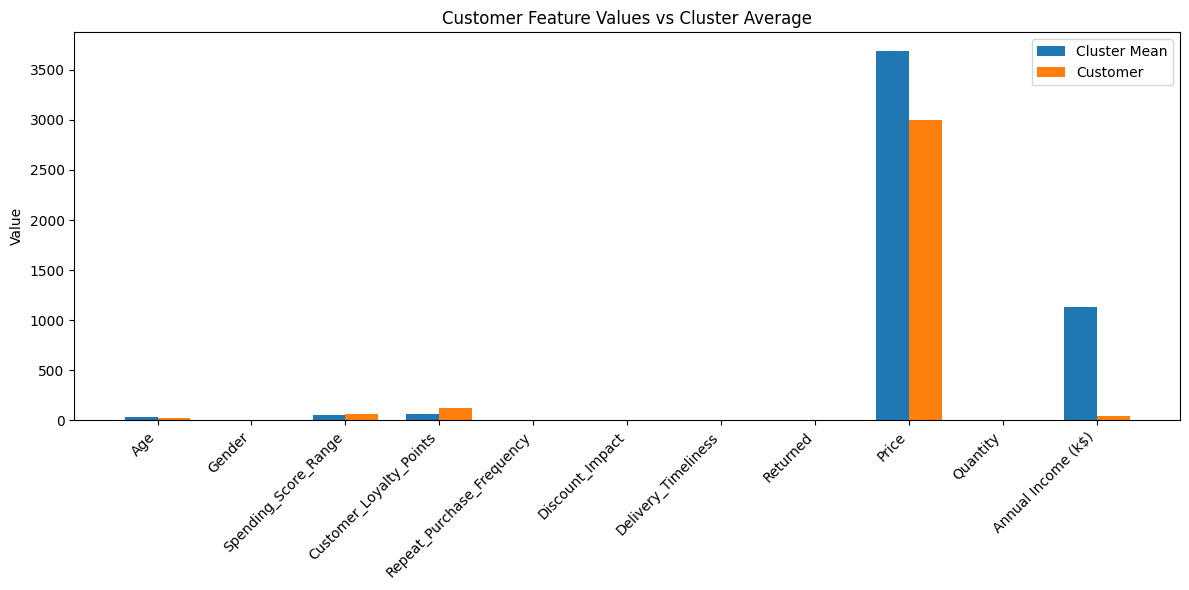

In [2]:
# Install necessary libraries (uncomment if not installed)
!pip install pandas numpy scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ----------- Step 1: Load your dataset -------------
# Replace 'your_dataset.csv' with your actual dataset path or upload manually
df = pd.read_csv('dataset.csv')

# ----------- Step 2: Select features for clustering -------------
# Choose numeric and encoded categorical features that describe customer behavior
features = [
    'Age', 'Gender', 'Spending_Score_Range', 'Customer_Loyalty_Points',
    'Repeat_Purchase_Frequency', 'Discount_Impact', 'Delivery_Timeliness',
    'Returned', 'Price', 'Quantity', 'Annual Income (k$)'
]

# ----------- Step 3: Clean and preprocess -------------

# Encode categorical columns (example)
cat_cols = ['Gender', 'Discount_Impact', 'Delivery_Timeliness', 'Returned']

# Clean Price column (remove currency symbols, commas, spaces, convert to float)
df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace(r'[^\d\.]', '', regex=True)
    .astype(float)
)

# Encode categorical columns with LabelEncoder
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# Extract features data
data = df[features].copy()

# Scale features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# ----------- Step 4: Clustering and Dimensionality Reduction -------------

# Train KMeans (assume 3 clusters for example)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)

# Add cluster labels to original dataframe for stats/plots
df['cluster'] = kmeans.labels_

# Fit PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
df['PC1'] = data_pca[:, 0]
df['PC2'] = data_pca[:, 1]

# ----------- Step 5: Cluster explanations (customize as you like) -------------
cluster_info = {
    "0": "Cluster 0: High loyalty, moderate spenders, mostly on-time deliveries.",
    "1": "Cluster 1: Younger customers, frequent returns, lower loyalty points.",
    "2": "Cluster 2: Older customers, high spenders, less returns, premium segment."
}

# ----------- Step 6: Define extended analysis function -------------

def extended_customer_analysis(customer_input, df, features, encoders, scaler, kmeans, pca):
    # Categorical columns to encode
    cat_cols = ['Gender', 'Discount_Impact', 'Delivery_Timeliness', 'Returned']

    # Prepare input vector in same order as features
    input_processed = []
    for feat in features:
        if feat in cat_cols:
            le = encoders[feat]
            val_enc = le.transform([customer_input[feat]])[0]
            input_processed.append(val_enc)
        elif feat == 'Price':
            # Clean price string like '$1999.99'
            price_clean = float(''.join(filter(lambda c: c.isdigit() or c=='.', str(customer_input[feat]))))
            input_processed.append(price_clean)
        else:
            input_processed.append(customer_input[feat])
    X = np.array(input_processed).reshape(1, -1)

    # Scale input
    X_scaled = scaler.transform(X)

    # Predict cluster
    cluster_label = kmeans.predict(X_scaled)[0]

    # Distance from cluster centroid
    dist = np.linalg.norm(X_scaled - kmeans.cluster_centers_[cluster_label])

    # PCA coordinates for plotting
    X_pca = pca.transform(X_scaled)[0]

    # Get cluster data subset for stats
    cluster_df = df[df['cluster'] == cluster_label]

    # Cluster statistics for selected features
    cluster_stats = cluster_df[features].describe().T[['mean', '50%', 'std']]
    cluster_stats.columns = ['Mean', 'Median', 'StdDev']

    # Calculate percentile ranks of customer features within cluster
    percentile_ranks = {}
    for feat in features:
        val = X[0, features.index(feat)]
        percent_rank = (cluster_df[feat] < val).mean() * 100
        percentile_ranks[feat] = percent_rank

    # Print results
    print(f"\n--- Predicted Cluster: {cluster_label} ---")
    print(f"Distance from cluster center (scaled): {dist:.4f}")
    print(f"Cluster explanation: {cluster_info.get(str(cluster_label), 'No info available')}\n")

    print("Customer input feature values:")
    for f, v in zip(features, X[0]):
        print(f"  {f}: {v}")

    print("\nPercentile ranks within cluster:")
    for f, p in percentile_ranks.items():
        print(f"  {f}: {p:.1f}th percentile")

    print("\nCluster summary statistics (mean ± std):")
    display(cluster_stats)

    # Visualization 1: PCA scatter plot with clusters and new customer
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=df, alpha=0.5, s=50)
    plt.scatter(X_pca[0], X_pca[1], c='red', s=200, marker='X', label='New Customer')
    plt.title("Customer Segments (PCA Projection)")
    plt.legend()
    plt.show()

    # Visualization 2: Bar plot comparing customer features vs cluster mean
    customer_vals = X[0]
    cluster_means = cluster_stats['Mean'].values
    plt.figure(figsize=(12,6))
    width = 0.35
    indices = np.arange(len(features))
    plt.bar(indices - width/2, cluster_means, width, label='Cluster Mean')
    plt.bar(indices + width/2, customer_vals, width, label='Customer')
    plt.xticks(indices, features, rotation=45, ha='right')
    plt.ylabel('Value')
    plt.title('Customer Feature Values vs Cluster Average')
    plt.legend()
    plt.tight_layout()
    plt.show()


# ----------- Step 7: Sample customer input (replace values with your own) -------------

sample_customer = {
    'Age': 28,
    'Gender': 'Male',
    'Spending_Score_Range': 60,
    'Customer_Loyalty_Points': 120,
    'Repeat_Purchase_Frequency': 3,
    'Discount_Impact': '10% Off',
    'Delivery_Timeliness': 'On time',
    'Returned': 'No',
    'Price': '$2999.00',
    'Quantity': 2,
    'Annual Income (k$)': 45
}

# ----------- Step 8: Run analysis -------------

extended_customer_analysis(sample_customer, df, features, encoders, scaler, kmeans, pca)


Saving dataset.csv to dataset (1).csv

➡️ This customer belongs to Cluster 0

Distances to all centroids: [0.918 1.854 1.202]

Cluster 0 summary:
- Number of customers: 177
- Avg Spending Score: 78.20
- Avg Price: ₹3297.51
- Avg Age: 33.7 years
  Age: 28 is at the 5.6th percentile in this cluster.
  Spending_Score_Range: 75 is at the 42.9th percentile in this cluster.
  Price: 2500 is at the 68.9th percentile in this cluster.


<ipython-input-4-8b620ccf84ba>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Age', 'Spending_Score_Range', 'Price'], inplace=True)
<ipython-input-4-8b620ccf84ba>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(X_scaled)
<ipython-input-4-8b620ccf84ba>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

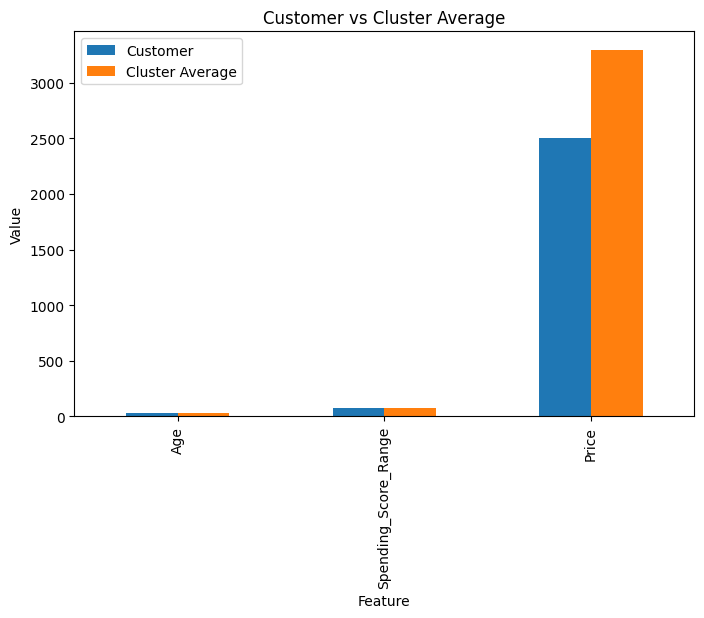


Top 5 similar customers:
    Customer_ID Customer_Name  Age  Spending_Score_Range    Price
386        C507         James   28                    78  2200.00
350        C470       Fardeen   29                    72  3000.00
268        C388         Swati   29                    73  1200.00
261        C382         Sneha   28                    74    22.00
337        C457       Dominic   28                    73     5.99

Feature importance (abs deviation from dataset mean):
Price                   1002.555110
Spending_Score_Range      25.179740
Age                        3.063864
dtype: float64


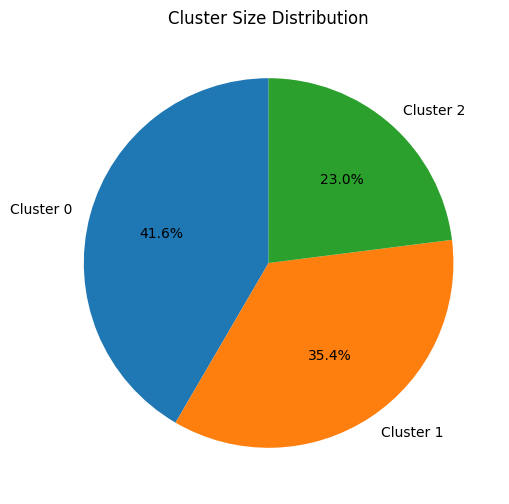

<ipython-input-4-8b620ccf84ba>:111: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


<ipython-input-4-8b620ccf84ba>:111: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




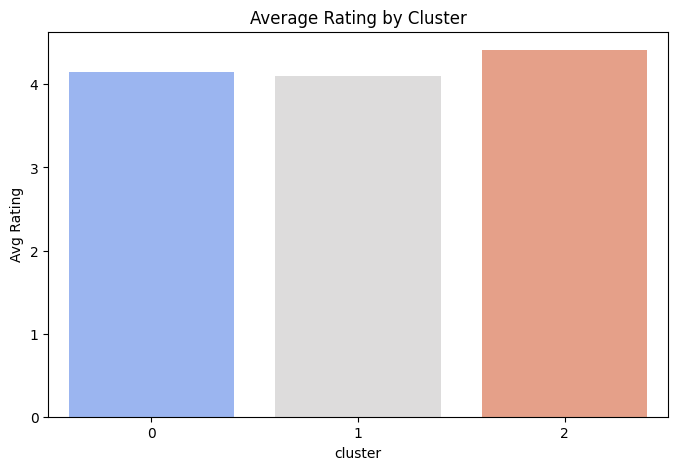

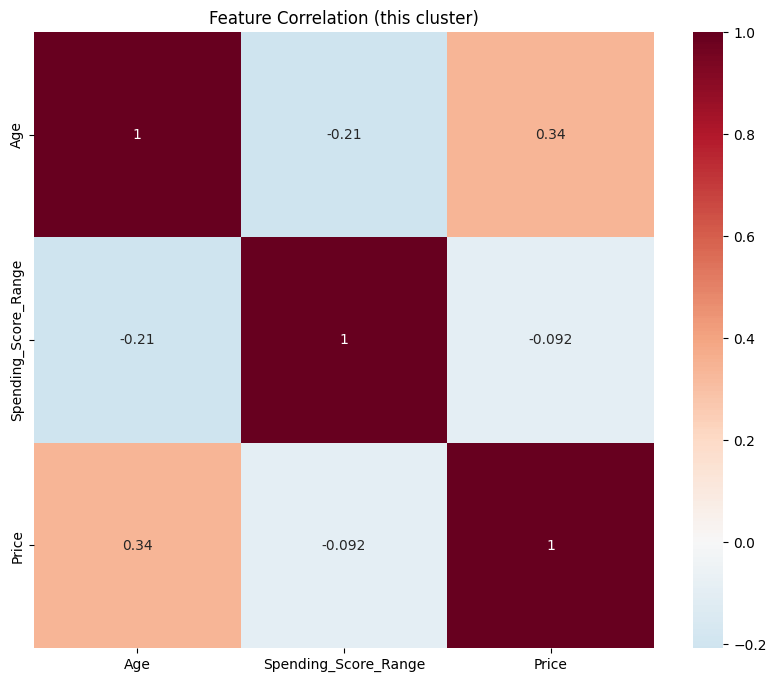

In [4]:
# Install libraries (for Google Colab)
!pip install pandas scikit-learn matplotlib seaborn plotly

# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import percentileofscore

# Upload CSV file (Google Colab)
from google.colab import files
uploaded = files.upload()

# Replace with your actual filename
df = pd.read_csv('/content/dataset.csv')

# Clean Price column to numeric
df['Price'] = df['Price'].astype(str).str.replace('₹', '').str.replace(',', '').str.replace('$', '').str.strip()
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Drop extra unnamed columns if any
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop rows with missing essential fields
df.dropna(subset=['Age', 'Spending_Score_Range', 'Price'], inplace=True)

# Select numeric features for clustering
features = ['Age', 'Spending_Score_Range', 'Price']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Dimensionality reduction (PCA)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Function for extended customer analysis
def extended_customer_analysis(input_data):
    input_scaled = scaler.transform([input_data])
    cluster = kmeans.predict(input_scaled)[0]
    print(f"\n➡️ This customer belongs to Cluster {cluster}")

    # Distances to centroids
    distances = np.linalg.norm(kmeans.cluster_centers_ - input_scaled, axis=1)
    print(f"\nDistances to all centroids: {distances.round(3)}")

    # Cluster overview
    cluster_df = df[df['cluster'] == cluster]
    print(f"\nCluster {cluster} summary:")
    print(f"- Number of customers: {len(cluster_df)}")
    print(f"- Avg Spending Score: {cluster_df['Spending_Score_Range'].mean():.2f}")
    print(f"- Avg Price: ₹{cluster_df['Price'].mean():.2f}")
    print(f"- Avg Age: {cluster_df['Age'].mean():.1f} years")

    # Percentile rank for each feature
    for i, feat in enumerate(features):
        rank = percentileofscore(cluster_df[feat], input_data[i])
        print(f"  {feat}: {input_data[i]} is at the {rank:.1f}th percentile in this cluster.")

    # Cluster scatter plot
    fig = px.scatter(df, x='PCA1', y='PCA2', color='cluster', title="PCA Scatterplot of Clusters")
    fig.add_scatter(x=[pca.transform(input_scaled)[0,0]], y=[pca.transform(input_scaled)[0,1]],
                    mode='markers+text', text=["New Customer"], marker=dict(size=15, color='black'))
    fig.show()

    # Bar plot comparing to cluster mean
    avg_features = cluster_df[features].mean()
    comp_df = pd.DataFrame({'Feature': features, 'Customer': input_data, 'Cluster Average': avg_features.values})
    comp_df.set_index('Feature').plot(kind='bar', figsize=(8,5))
    plt.title("Customer vs Cluster Average")
    plt.ylabel("Value")
    plt.show()

    # Similar customers (5 nearest)
    cluster_data_scaled = scaler.transform(cluster_df[features])
    distances = cdist(input_scaled, cluster_data_scaled, 'euclidean').flatten()
    nearest_indices = distances.argsort()[:5]
    print("\nTop 5 similar customers:")
    print(cluster_df.iloc[nearest_indices][['Customer_ID', 'Customer_Name', 'Age', 'Spending_Score_Range', 'Price']])

    # Feature importance (mean deviation)
    overall_mean = df[features].mean()
    cluster_mean = cluster_df[features].mean()
    importance = (cluster_mean - overall_mean).abs().sort_values(ascending=False)
    print("\nFeature importance (abs deviation from dataset mean):")
    print(importance)

    # Cluster size pie chart
    plt.figure(figsize=(6,6))
    df['cluster'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=[f'Cluster {i}' for i in range(kmeans.n_clusters)])
    plt.title("Cluster Size Distribution")
    plt.ylabel("")
    plt.show()

    # Rating by cluster (if exists)
    if 'Rating' in df.columns:
        plt.figure(figsize=(8,5))
        sns.barplot(x='cluster', y='Rating', data=df, ci=None, palette='coolwarm')
        plt.title("Average Rating by Cluster")
        plt.ylabel("Avg Rating")
        plt.show()

    # Correlation heatmap for this cluster
    plt.figure(figsize=(10,8))
    sns.heatmap(cluster_df[features].corr(), annot=True, cmap='RdBu_r', center=0)
    plt.title("Feature Correlation (this cluster)")
    plt.show()

# Example new customer: [Age, Spending_Score, Price]
new_customer = [28, 75, 2500]
extended_customer_analysis(new_customer)
